In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from alerce_classifiers.classifiers.mlp import MLPClassifier
from alerce_classifiers.classifiers.random_forest import RandomForestClassifier
from alerce_classifiers.classifiers.hierarchical_random_forest import (
    HierarchicalRandomForestClassifier,
)
from alerce_classifiers.classifiers.lightgbm import LightGBMClassifier
from alerce_classifiers.classifiers.xgboost import XGBoostClassifier

2024-11-20 12:30:05.686634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732105805.719443 3178444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732105805.729063 3178444 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 12:30:05.766561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np
import pandas as pd
import os


model_path = "models/hrf_classifier_20241120-115822"
file_path = os.path.join(model_path, "hierarchical_random_forest_model.pkl")
hrf_dict = pd.read_pickle(file_path)

feature_list = hrf_dict["feature_list"]
rf_name_list = []
importances_list = []
for rf_name, rf_model in hrf_dict["model"].items():
    rf_name_list.append(rf_name)
    importances_list.append(rf_model.feature_importances_)

df_importances = pd.DataFrame(
    data=np.stack(importances_list, axis=1), columns=rf_name_list, index=feature_list
)

for column in df_importances.columns:
    print(df_importances.sort_values(column, ascending=False).iloc[:30][column])
    print("-" * 20)



W1_W2                             0.085595
sgscore1                          0.050391
W2_W3                             0.044131
r_W2                              0.040553
mean_sharpnr_12                   0.040072
r_W4                              0.036640
W3_W4                             0.034685
r_W3                              0.033821
mean_distnr_12                    0.033428
r_W1                              0.032895
g_W2                              0.029098
positive_fraction_1               0.026458
distpsnr1                         0.026160
mean_chinr_12                     0.025742
g_W4                              0.023359
g_W3                              0.021550
MHPS_high_1                       0.021121
g_W1                              0.018106
positive_fraction_2               0.016437
MHPS_high_2                       0.015338
dbrightness_forced_phot_band_1    0.011607
SPM_chi_2                         0.010211
ulens_chi_1                       0.009573
GP_DRW_tau_

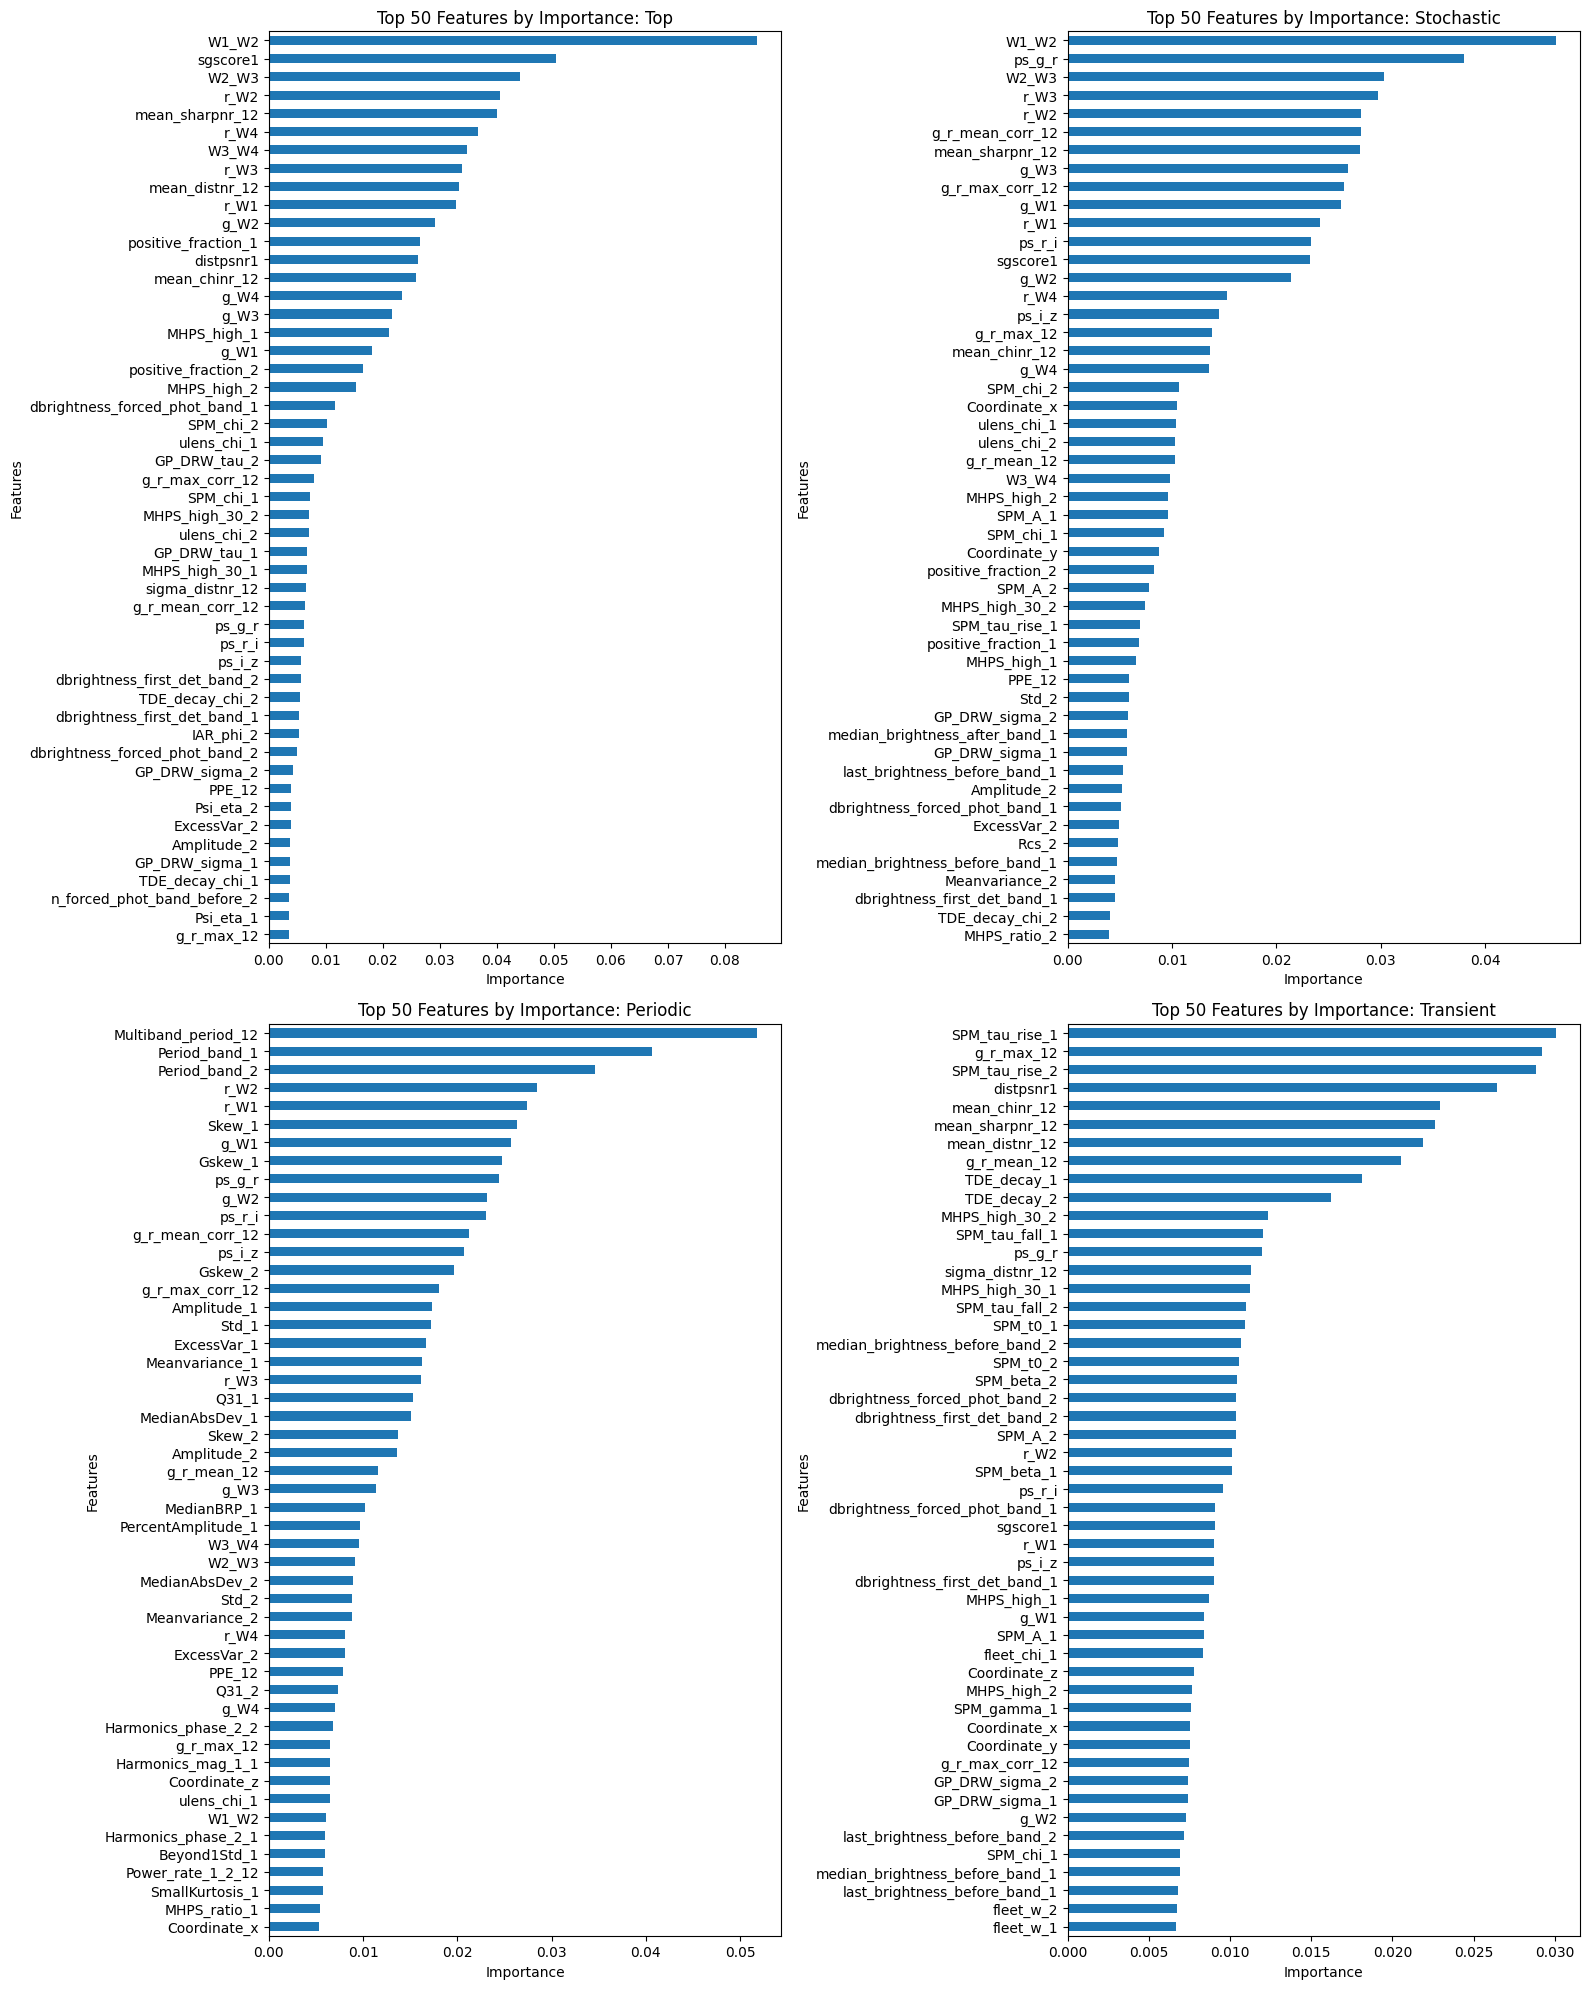

In [4]:
# Automatically adjusting the number of features and plot size based on the DataFrame
top_n = 50  # You can adjust this number, or make it dynamic if needed
features_to_plot = min(top_n, len(df_importances))  # Limit to the actual number of features
sorted_top_n = {col: df_importances.sort_values(col, ascending=False).iloc[:features_to_plot][col]
                for col in df_importances.columns}

# Dynamically setting figure size based on the number of features
fig_height = features_to_plot * 0.4  # Adjust height scaling factor if needed
fig, axs = plt.subplots(2, 2, figsize=(16, fig_height))

for ax, (col, values) in zip(axs.ravel(), sorted_top_n.items()):
    values.plot(kind='barh', ax=ax)
    ax.set_title(f"Top {features_to_plot} Features by Importance: {col.capitalize()}")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Features")
    ax.invert_yaxis()  # To show the highest value at the top

plt.tight_layout()
plt.show()


In [5]:
df_importances.sort_values(col, ascending=False)['transient']

SPM_tau_rise_1    0.030044
g_r_max_12        0.029210
SPM_tau_rise_2    0.028843
distpsnr1         0.026444
mean_chinr_12     0.022934
                    ...   
Con_2             0.000581
MHPS_PN_flag_2    0.000558
Con_1             0.000495
Pvar_1            0.000430
Pvar_2            0.000422
Name: transient, Length: 199, dtype: float64

In [6]:
# Sorting the DataFrame by the "transient" column in descending order
sorted_features = df_importances.sort_values("transient", ascending=False)

# Saving the feature names and their importance to a CSV file
csv_path = f"{model_path}/sorted_transient_features_importance.csv"
sorted_features[["transient"]].to_csv(csv_path, index=True)
sorted_features[["transient"]]

,transient
SPM_tau_rise_1,0.030044
g_r_max_12,0.029210
SPM_tau_rise_2,0.028843
distpsnr1,0.026444
mean_chinr_12,0.022934
...,...
Con_2,0.000581
MHPS_PN_flag_2,0.000558
Con_1,0.000495
Pvar_1,0.000430


In [7]:
df_feat = pd.read_csv(csv_path, index_col=0)
df_feat.index[:top_n]

Index(['SPM_tau_rise_1', 'g_r_max_12', 'SPM_tau_rise_2', 'distpsnr1',
       'mean_chinr_12', 'mean_sharpnr_12', 'mean_distnr_12', 'g_r_mean_12',
       'TDE_decay_1', 'TDE_decay_2', 'MHPS_high_30_2', 'SPM_tau_fall_1',
       'ps_g_r', 'sigma_distnr_12', 'MHPS_high_30_1', 'SPM_tau_fall_2',
       'SPM_t0_1', 'median_brightness_before_band_2', 'SPM_t0_2', 'SPM_beta_2',
       'dbrightness_forced_phot_band_2', 'dbrightness_first_det_band_2',
       'SPM_A_2', 'r_W2', 'SPM_beta_1', 'ps_r_i',
       'dbrightness_forced_phot_band_1', 'sgscore1', 'r_W1', 'ps_i_z',
       'dbrightness_first_det_band_1', 'MHPS_high_1', 'g_W1', 'SPM_A_1',
       'fleet_chi_1', 'Coordinate_z', 'MHPS_high_2', 'SPM_gamma_1',
       'Coordinate_x', 'Coordinate_y', 'g_r_max_corr_12', 'GP_DRW_sigma_2',
       'GP_DRW_sigma_1', 'g_W2', 'last_brightness_before_band_2', 'SPM_chi_1',
       'median_brightness_before_band_1', 'last_brightness_before_band_1',
       'fleet_w_2', 'fleet_w_1'],
      dtype='object')